In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

In [8]:
# Normalize images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
print(len(train_images))

50000


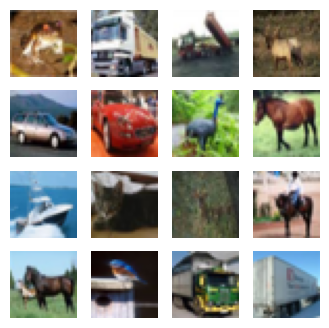

In [9]:
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((train_images[i, :, :, :] + 1) / 2)
    plt.axis('off')
plt.show()

In [17]:
# Define parameters
BUFFER_SIZE = 50000
BATCH_SIZE = 128
EPOCHS = 50
NOISE_DIM = 100

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(len(train_dataset))

391


In [18]:
# Generator model
def make_generator_model():
    model = models.Sequential()
    model.add(layers.Dense(4 * 4 * 256, input_shape=(NOISE_DIM,)))

    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))

    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))

    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='tanh'))
    return model

# Discriminator model
def make_discriminator_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model
# Define the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()


In [19]:
generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,259 (2.99 MB)

 Trainable params: 784,259 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,841 (327.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:

# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



In [22]:
# Training loop
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    print(f'Epoch {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')




Epoch 1, Generator Loss: 2.6264913082122803, Discriminator Loss: 0.5139504671096802
Epoch 2, Generator Loss: 1.4981231689453125, Discriminator Loss: 0.6795517206192017
Epoch 3, Generator Loss: 1.6406549215316772, Discriminator Loss: 0.6776218414306641
Epoch 4, Generator Loss: 1.6767473220825195, Discriminator Loss: 0.5272737741470337
Epoch 5, Generator Loss: 1.4655768871307373, Discriminator Loss: 0.8085254430770874
Epoch 6, Generator Loss: 1.236860752105713, Discriminator Loss: 1.036364197731018
Epoch 7, Generator Loss: 1.291160225868225, Discriminator Loss: 0.7644217610359192
Epoch 8, Generator Loss: 0.9288320541381836, Discriminator Loss: 1.237398624420166
Epoch 9, Generator Loss: 1.0135293006896973, Discriminator Loss: 1.1560180187225342
Epoch 10, Generator Loss: 1.0067083835601807, Discriminator Loss: 1.1673601865768433
Epoch 11, Generator Loss: 0.7306069135665894, Discriminator Loss: 1.4282680749893188
Epoch 12, Generator Loss: 1.069582223892212, Discriminator Loss: 1.29456031322

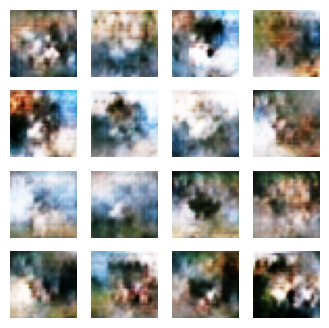

In [23]:
# Generate and plot some images
noise = tf.random.normal([16, NOISE_DIM])
generated_images = generator(noise, training=False)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i, :, :, :] + 1) / 2)
    plt.axis('off')
plt.show()